In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import function as fc
import scipy.stats as stats
from datetime import datetime, timedelta
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 定义参数

In [2]:
#参数
#数据字段数
num_fields = 32 
#数据路径
path = '/Users/wanghao/jupyter/data/2022_ncbdc/LB_04/part-00000-d927b640-ae1a-4cad-a86b-77d14c14c00c-c000.csv'
# 车辆属性值
attributes = ['vid', 'mode', 'sing_temp_num', 'sing_volt_num']

# 导入数据

In [3]:
#导入数据
data = fc.import_and_check_data(path, num_fields)

Data Shape: (687634, 32)
Data Columns: Index(['vid', 'yr_modahrmn', 'speed', 'vehicle_state', 'charging_status',
       'mode', 'total_volt', 'total_current', 'mileage', 'standard_soc',
       'cell_volt_list', 'max_cell_volt', 'max_volt_cell_id', 'min_cell_volt',
       'min_cell_volt_id', 'max_temp', 'max_temp_probe_id', 'min_temp',
       'min_temp_probe_id', 'max_alarm_lvl', 'bat_fault_list', 'isulate_r',
       'dcdc_stat', 'sing_temp_num', 'sing_volt_num', 'cell_temp_list', 'gear',
       'max_volt_num', 'min_volt_num', 'max_temp_num', 'min_temp_num',
       'alarm_info'],
      dtype='object')
数据字段齐全


In [4]:
attributes_results = fc.extract_vehicle_attributes(data, attributes)
print(attributes_results)
sing_temp_num = attributes_results['sing_temp_num']
sing_volt_num = attributes_results['sing_volt_num']

{'vid': '262f592320fa4dbcb9beb2853208900b', 'mode': 1, 'sing_temp_num': 34, 'sing_volt_num': 95}


# 删除重复值

In [5]:
data = fc.drop_duplicated(data)

删除重复数据前： (687634, 32)
删除重复的行数为： 15990
删除重复数据后： (671644, 32)


# 处理时间列

In [6]:
data = fc.time_preprocessing(data,time_col='yr_modahrmn',format='%Y-%m-%d %H:%M:%S')

数据的总时间跨度为： 182 days 18:38:39
最小采样间隔为： 0 days 00:00:09
平均采样间隔为： 0 days 00:00:23.512370411
最大采样间隔为： 1 days 17:39:44


In [7]:
#查看缺失值
data.isnull().sum()

vid                       0
speed                     0
vehicle_state             2
charging_status           0
mode                      0
total_volt                0
total_current             0
mileage                   0
standard_soc              0
cell_volt_list            0
max_cell_volt             0
max_volt_cell_id          0
min_cell_volt             0
min_cell_volt_id          0
max_temp                  2
max_temp_probe_id         0
min_temp                  0
min_temp_probe_id         0
max_alarm_lvl             0
bat_fault_list       671644
isulate_r                 0
dcdc_stat                 0
sing_temp_num             0
sing_volt_num             0
cell_temp_list            0
gear                      0
max_volt_num              0
min_volt_num              0
max_temp_num              0
min_temp_num              0
alarm_info                0
dtype: int64

# 充电片段划分

In [8]:
chagring_segments = fc.identify_charging_segments(data)
charging_details = fc.calculate_segment_details(data,chagring_segments)
driving_segments = fc.identify_driving_segments(data)
driving_details = fc.calculate_segment_details(data,driving_segments)

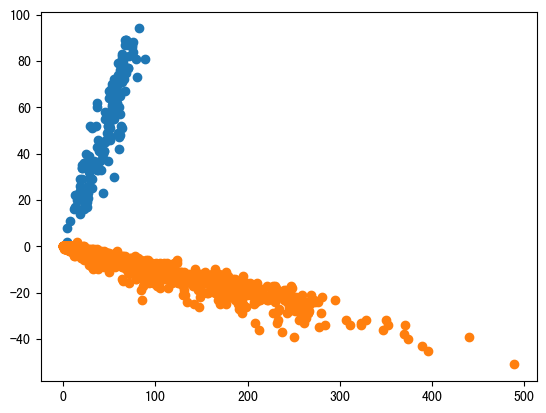

In [9]:
#以duration为横坐标，soc_change为纵坐标，画出散点图
plt.scatter(charging_details['duration'],charging_details['soc_change'])
plt.scatter(driving_details['duration'],driving_details['soc_change'])

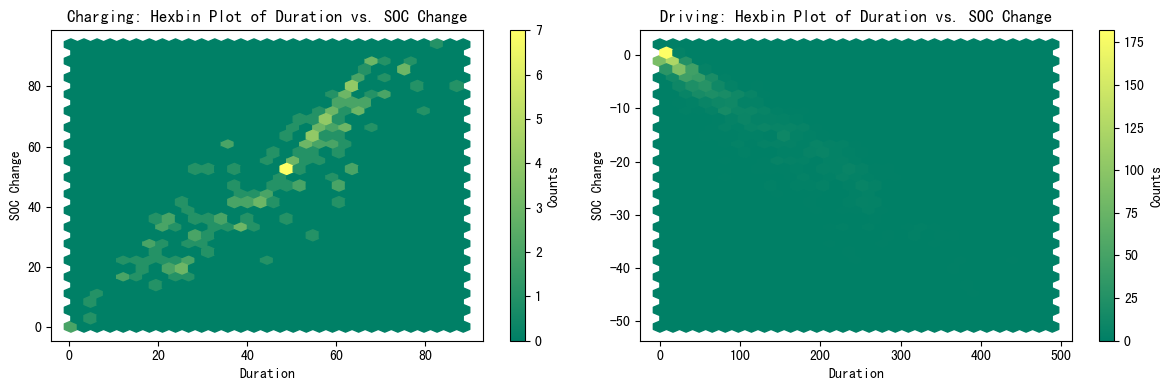

In [10]:
# 创建一个包含两个子图的图表
plt.figure(figsize=(12, 4))
# 第一个子图：充电数据的六边形蜂窝图
plt.subplot(1, 2, 1)
hb_charging = plt.hexbin(charging_details['duration'], charging_details['soc_change'], gridsize=30, cmap='summer')
plt.title('Charging: Hexbin Plot of Duration vs. SOC Change')
plt.xlabel('Duration')
plt.ylabel('SOC Change')
plt.colorbar(hb_charging, label='Counts')

# 第二个子图：驾驶数据的六边形蜂窝图
plt.subplot(1, 2, 2)
hb_driving = plt.hexbin(driving_details['duration'], driving_details['soc_change'], gridsize=30,cmap='summer')
plt.title('Driving: Hexbin Plot of Duration vs. SOC Change')
plt.xlabel('Duration')
plt.ylabel('SOC Change')
plt.colorbar(hb_driving, label='Counts')

# 调整子图布局，避免重叠
plt.tight_layout()
plt.show()

# 处理单体电池电压温度数据

In [11]:
# 使用apply函数处理整个列
data['cell_volt_list'] = data['cell_volt_list'].apply(fc.process_string)
data['cell_temp_list'] = data['cell_temp_list'].apply(fc.process_string)
# 使用expand_columns函数展开列
data=fc.expand_columns(data)

# 提取片段

In [12]:
def extract_segments_with_id(data, segments, column_name):
    segment_data_list = []
    for idx, (start, end) in enumerate(segments, 1):
        segment_data = data[(data.index >= start) & (data.index <= end)].copy()
        segment_data[column_name] = idx
        segment_data_list.append(segment_data)
    return segment_data_list

# Assuming you have defined and executed the get_charging_segments and get_driving_segments functions

charging_data_segments_with_id = extract_segments_with_id(data, chagring_segments, 'charging_segment_id')
driving_data_segments_with_id = extract_segments_with_id(data, driving_segments, 'driving_segment_id')

In [13]:
def concatenate_segments(segments_list):
    return pd.concat(segments_list)

charging_total_data_with_id = concatenate_segments(charging_data_segments_with_id)
driving_total_data_with_id = concatenate_segments(driving_data_segments_with_id)

In [14]:
#找到charging_total_data_with_id中'max_alarm_lvl'不为0的数据
charging_total_data_with_id[charging_total_data_with_id['max_alarm_lvl']!=0]

,vid,speed,vehicle_state,charging_status,mode,total_volt,total_current,mileage,standard_soc,cell_volt_list,...,cell_temp_25,cell_temp_26,cell_temp_27,cell_temp_28,cell_temp_29,cell_temp_30,cell_temp_31,cell_temp_32,cell_temp_33,charging_segment_id
time,,,,,,,,,,,,,,,,,,,,,


In [15]:
# # 遍历每一个cell_volt并绘制图像
# for driving_segment_id in range(1,20):#len(driving_segments) + 1
#     plt.figure(figsize=(20, 8))
#     for cell_volt_idx in range(sing_volt_num):
#         col_name = f'cell_volt_{cell_volt_idx}'
#         selected_data = driving_total_data_with_id[driving_total_data_with_id['driving_segment_id'] == driving_segment_id]
#         #plt.plot(selected_data[col_name], label=col_name)
#         #plt.plot(selected_data["max_alarm_lvl"] * 200 + 3400)
#         plt.plot(selected_data["mileage"])
    
#     plt.title(f'Driving Segment {driving_segment_id} - Cell Voltages')
#     plt.xlabel('Time')
#     plt.ylabel('Voltage')
#     #plt.legend()
#     plt.grid()
#     plt.show()


In [16]:
# # 遍历每一个cell_volt并绘制图像
# for charging_segment_id in range(1, len(chagring_segments)+1):  #未来修改为len(chagring_segments)+1
#     plt.figure(figsize=(20, 8))
#     for cell_volt_idx in range(sing_temp_num):
#         col_name = f'cell_temp_{cell_volt_idx}'
#         selected_data = charging_total_data_with_id[charging_total_data_with_id['charging_segment_id'] == charging_segment_id]
#         plt.plot(selected_data[col_name], label=col_name)
#         #plt.plot(selected_data["max_alarm_lvl"]*200+3400)
    
#     plt.title(f'Charging Segment {charging_segment_id} - Cell Voltages')
#     plt.xlabel('Time')
#     plt.ylabel('Voltage')
#     #plt.legend()
#     plt.grid()
#     plt.show()


In [17]:
# data.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_24/预处理后数据/2022_ncbdc_LB_04_预处理后数据.csv')
# charging_total_data.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_24/预处理后数据/2022_ncbdc_LB_04_充电片段数据.csv')
# driving_total_data.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_24/预处理后数据/2022_ncbdc_LB_04_行驶片段数据.csv')

In [18]:
# data_demo = data[0:10000]
# data_demo.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_04/预处理后数据/demo_2022_ncbdc_LB_04_预处理后数据.csv')
# charging_total_data_demo = charging_total_data[0:10000]
# charging_total_data_demo.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_04/预处理后数据/demo_2022_ncbdc_LB_04_充电总数据.csv')
# driving_total_data_demo = driving_total_data[0:10000]
# driving_total_data_demo.to_csv('/Users/wanghao/jupyter/data/2022_ncbdc/LB_04/预处理后数据/demo_2022_ncbdc_LB_04_行驶总数据.csv')


# 实验区

In [19]:
# data['cell_volt_discrepancy_std'] = data['cell_volt_list'].apply(lambda x: pd.Series(x).std())

In [20]:
# def entropy_of_list(values):
#     """计算列表的熵，忽略空值"""
#     # 忽略None和NaN
#     values = [value for value in values if value is not None and not np.isnan(value)]
#     _, counts = np.unique(values, return_counts=True)
#     probabilities = counts / len(values)
#     entropy = -np.sum(probabilities * np.log2(probabilities))
#     return entropy

# data['cell_volt_discrepancy_entropy'] = data['cell_volt_list'].apply(entropy_of_list)

In [21]:
# test_start_time = '2020-04-28 13:00:00'
# test_end_time = '2020-04-28 16:00:00'
# columns_to_plot = ["standard_soc","vehicle_state", "charging_status", "speed", "mileage", 
#                    ]
# fc.plot_selected_columns(data, test_start_time, test_end_time, columns_to_plot)

In [22]:
# test_start_time = '2020-10-27 00:00:00'
# test_end_time = '2020-10-28 12:00:00'
# columns_to_plot = ["standard_soc", "charging_status", "speed", "max_alarm_lvl", 
#                    "total_volt", "total_current", "max_cell_volt", "max_temp",'cell_volt_discrepancy_std','cell_volt_discrepancy_entropy']
# fc.plot_selected_columns(data, test_start_time, test_end_time, columns_to_plot)

In [23]:
# # 选择需要检验的列
# volt_columns = [f'cell_volt_{i}' for i in range(10)]

# # 选择需要检查的数据
# checking_normality_data = charging_total_data


# for column in volt_columns:
#     print(f"Testing {column} for normality")
    
#     # 直方图
#     plt.hist(checking_normality_data[column].dropna(), bins=30, density=True, alpha=0.6, color='g')
    
#     # 拟合参数
#     mu, std = stats.norm.fit(checking_normality_data[column].dropna())
    
#     # 画出相应的正态分布曲线
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p = stats.norm.pdf(x, mu, std)
#     plt.plot(x, p, 'k', linewidth=2)
    
#     plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")
#     plt.show()
    
#     # QQ图
#     stats.probplot(checking_normality_data[column].dropna(), plot=plt)
#     plt.title(f"QQ plot for {column}")
#     plt.show()
    
#     # 进行Kolmogorov-Smirnov检验
#     print(f"Testing {column} for normality using Kolmogorov-Smirnov test")

#     # 删除空值
#     col_data = checking_normality_data[column].dropna()

#     # 计算平均值和标准差
#     mu, std = np.mean(col_data), np.std(col_data)

#     # 进行Kolmogorov-Smirnov检验
#     ks_test = stats.kstest(col_data, 'norm', args=(mu, std))

#     print(f"Kolmogorov-Smirnov test for {column}: statistic={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.4f}\n")
    


In [24]:


# # Define features of interest for exploration
# features_to_explore = ['speed', 'total_current', 'standard_soc', 'max_cell_volt', 'min_cell_volt', 'max_temp', 'min_temp', 'alarm_info']

# # Plot histograms for each feature
# plt.figure(figsize=(15, 20))
# for idx, feature in enumerate(features_to_explore, 1):
#     plt.subplot(len(features_to_explore), 1, idx)
#     sns.histplot(data[feature], bins=50, kde=True)
#     plt.title(f'Distribution of {feature}')
#     plt.xlabel('')
#     plt.tight_layout()

# plt.show()


In [25]:
# # Plotting time series of the features to observe trends and anomalies
# plt.figure(figsize=(15, 20))
# for idx, feature in enumerate(features_to_explore, 1):
#     plt.subplot(len(features_to_explore), 1, idx)
#     plt.plot(data[feature])
#     plt.title(f'Time Series of {feature}')
#     plt.xlabel('Time')
#     plt.ylabel(feature)
#     plt.tight_layout()

# plt.show()

In [26]:
# fc.analyze_column(data, 'max_alarm_lvl',0,3)

In [27]:
# fc.analyze_column(data, 'alarm_info')

In [28]:
# data['alarm_info'].unique()

In [29]:
# # 查看'alarm_info'不为0时候，'max_alarm_lvl'为3的数据
# data[(data['alarm_info'] != 0) & (data['max_alarm_lvl'] == 3)]

In [30]:
# data['alarm_decoded'] = data['alarm_info'].apply(fc.decode_alarm)

In [31]:
# # 将列表转换为字符串以便查找唯一值
# data['alarm_decoded_str'] = data['alarm_decoded'].apply(lambda x: ', '.join(x))

# # 获取该列的所有唯一值
# unique_values = data[data['max_alarm_lvl'] == 3]['alarm_decoded_str'].unique()

# # 打印唯一值
# for value in unique_values:
#     print(value)
